In [33]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

dataset = torchvision.datasets.ImageFolder(root='CWTImages', transform=transform)

BATCH_SIZE = 32
data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [34]:
model = torchvision.models.resnet18(pretrained=True)

C:\Users\Anders\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Anders\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
EPOCHS = 15
LEARNING_RATE = 0.001

SEQ_LENGTH = 120
N_CLASSES = 7
DATA_SETS = dataset.classes
DATA_SETS_F = dataset.classes

#Create result PATH
name = "CWT_CLASSIFICATION_"
name += str(N_CLASSES) + "_"
for datasets in DATA_SETS:
    name += datasets + "_"
name += "seqLen" + str(SEQ_LENGTH) + "_" + "BATCH" + str(BATCH_SIZE) + "_" + "EPOCHS" +  str(EPOCHS) + "_" +  "LR" + str(LEARNING_RATE)
RESULT_PATH = "Results/CWT - Classification/" + name
OVERWRITE_SEQUENCES = False
SEQUENCE_NAME = "SEQUENCES_"+ name +".pkl"

In [36]:
#See Rows in dataset
dataset.classes

['Friction',
 'Friction_low',
 'Normal',
 'RampDown',
 'RampUp',
 'Vibration',
 'Vibration_low']

In [37]:
DATA_SETS_F

['Friction',
 'Friction_low',
 'Normal',
 'RampDown',
 'RampUp',
 'Vibration',
 'Vibration_low']

In [38]:
for param in model.parameters():
    param.requires_grad = False

In [39]:
model.fc = torch.nn.Linear(512, len(dataset.classes))

In [40]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)

for epoch in range(EPOCHS):
    for inputs, labels in data_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print('Epoch: {} Loss: {:.4f}'.format(epoch + 1, loss.item()))

Epoch: 1 Loss: 0.5299
Epoch: 2 Loss: 0.6161
Epoch: 3 Loss: 0.5889
Epoch: 4 Loss: 0.4059
Epoch: 5 Loss: 0.6485
Epoch: 6 Loss: 0.6244
Epoch: 7 Loss: 0.4883
Epoch: 8 Loss: 0.7256
Epoch: 9 Loss: 0.5231
Epoch: 10 Loss: 0.7433
Epoch: 11 Loss: 0.3190
Epoch: 12 Loss: 0.2491
Epoch: 13 Loss: 0.4040
Epoch: 14 Loss: 0.6234
Epoch: 15 Loss: 0.6780


In [41]:
dataset_test = torchvision.datasets.ImageFolder(root='CWTImagesTest', transform=transform)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)

In [42]:
# Test the model
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in data_loader_test:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: {:.2f}%'.format(100 * correct / total))


Accuracy: 74.71%


In [43]:
# Confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in data_loader_test:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())




In [44]:
len(y_true), len(y_pred)

(1400, 1400)

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_true, y_pred, target_names=DATA_SETS_F)
print( report )

with open(RESULT_PATH + ".txt", "w") as f:
    f.write(report)

               precision    recall  f1-score   support

     Friction       1.00      1.00      1.00       200
 Friction_low       0.28      0.21      0.24       200
       Normal       1.00      1.00      1.00       200
     RampDown       0.72      0.37      0.49       114
       RampUp       0.79      0.94      0.86       286
    Vibration       1.00      1.00      1.00       200
Vibration_low       0.37      0.46      0.41       200

     accuracy                           0.75      1400
    macro avg       0.74      0.71      0.71      1400
 weighted avg       0.74      0.75      0.74      1400



In [46]:
import pandas as pd

def show_confusion_matrix(confusion_matrix, path):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_tick_params(rotation=0)
    hmap.xaxis.set_tick_params(rotation=45)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path,  bbox_inches="tight")

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=DATA_SETS_F, columns=DATA_SETS_F)

df_cm



,Friction,Friction_low,Normal,RampDown,RampUp,Vibration,Vibration_low
Friction,200,0,0,0,0,0,0
Friction_low,0,43,0,0,0,0,157
Normal,0,0,200,0,0,0,0
RampDown,0,0,0,42,72,0,0
RampUp,0,0,0,16,270,0,0
Vibration,0,0,0,0,0,200,0
Vibration_low,0,109,0,0,0,0,91


Results/CWT - Classification/CWT_CLASSIFICATION_7_Friction_Friction_low_Normal_RampDown_RampUp_Vibration_Vibration_low_seqLen120_BATCH32_EPOCHS15_LR0.001_confusion_matrix.png


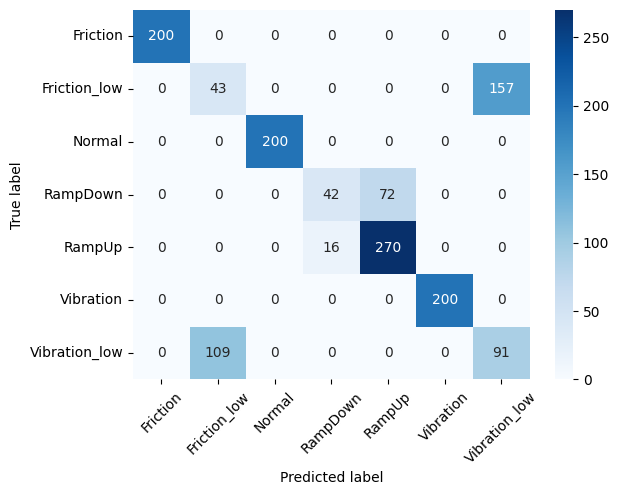

In [47]:
print(RESULT_PATH + "_confusion_matrix.png")
show_confusion_matrix(df_cm, RESULT_PATH + ".png")

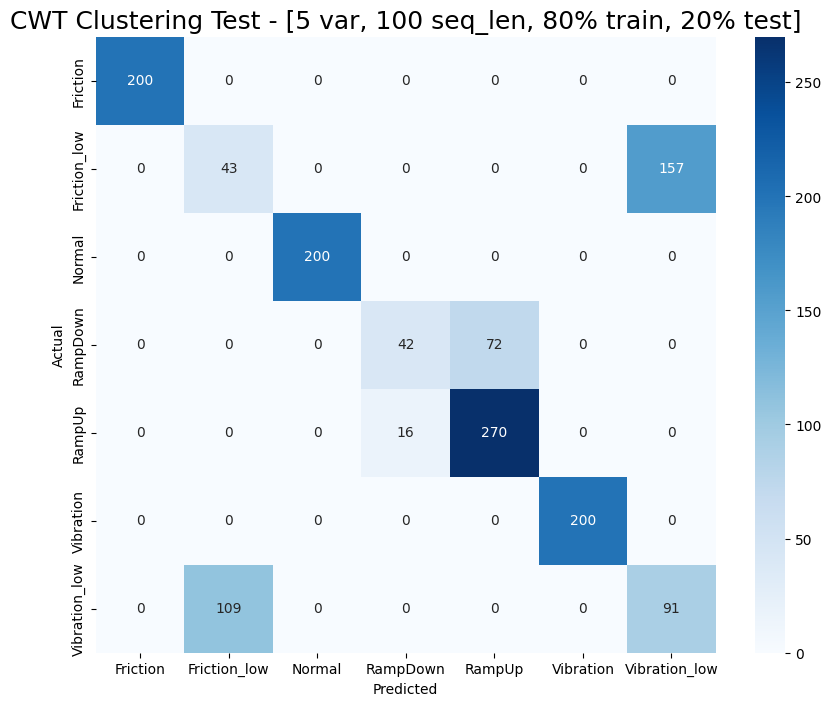

In [48]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.title('CWT Clustering Test - [5 var, 100 seq_len, 80% train, 20% test]', fontsize=18, )
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [49]:
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in data_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())


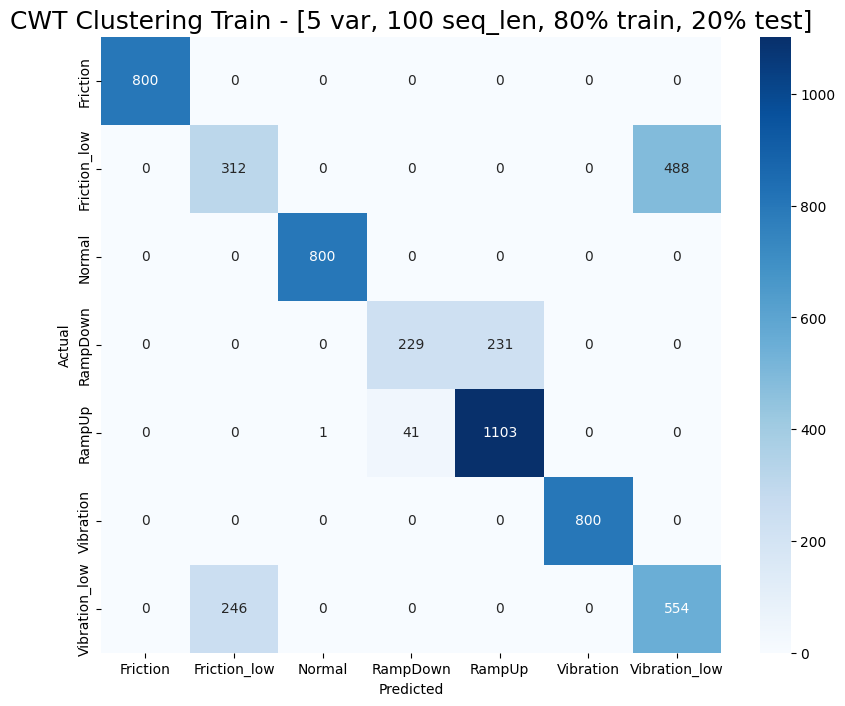

In [50]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.title('CWT Clustering Train - [5 var, 100 seq_len, 80% train, 20% test]', fontsize=18, )
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()